In [2]:
import numpy as np
import pandas as pd
import json
from glob import glob


In [ ]:

def generate_realistic_taxi_data(anomaly_ratio=0.05, output_file="realistic_taxi_data.csv"):
   
    # Load route coordinates from JSON files
    json_files = glob("routes/*.json")
    
    # If no route files found, generate synthetic coordinates
    if not json_files:
        print("No route files found. Generating synthetic route data...")
        num_points = 5000
        all_latitudes = np.cumsum(np.random.normal(0, 0.0001, num_points)) + 40.7
        all_longitudes = np.cumsum(np.random.normal(0, 0.0001, num_points)) - 74.0
    else:
        # Extract coordinates from route files
        all_latitudes, all_longitudes = [], []
        for file in json_files:
            with open(file, "r") as f:
                route_data = json.load(f)
                coordinates = route_data["geometry"]["coordinates"]
                longitudes, latitudes = zip(*coordinates)
                all_latitudes.extend(latitudes)
                all_longitudes.extend(longitudes)

    num_points = len(all_latitudes)
    time_steps = np.arange(0, num_points)
    
    # Step 1: Generate normal baseline data with realistic distributions
    
    # Environmental factors
    road_type = np.random.choice([0, 1, 2], size=num_points, p=[0.4, 0.4, 0.2])  # 0=Highway, 1=City, 2=Rural
    road_condition = np.random.choice([0, 1, 2, 3], size=num_points, p=[0.6, 0.2, 0.1, 0.1])  # 0=Dry, 1=Wet, 2=Snow, 3=Ice
    time_of_day = np.random.choice([0, 1, 2, 3], size=num_points, p=[0.2, 0.25, 0.3, 0.25])  # 0=Night, 1=Morning, 2=Afternoon, 3=Evening
    traffic_condition = np.random.choice([0, 1, 2], size=num_points, p=[0.5, 0.3, 0.2])  # 0=Light, 1=Moderate, 2=Heavy
    
    # Define speed limits based on road type
    speed_limits_map = {0: 100, 1: 40, 2: 60}  # km/h (Highway, City, Rural)
    speed_limit = np.array([speed_limits_map[rt] for rt in road_type])
    
    # Calculate realistic normal speed based on conditions
    # Adjust speed based on road conditions
    road_condition_factor = np.where(road_condition == 3, 0.6,  # Ice
                             np.where(road_condition == 2, 0.75, # Snow
                             np.where(road_condition == 1, 0.9,  # Wet
                                                          1.0))) # Dry
    
    # Adjust speed based on traffic conditions
    traffic_factor = np.where(traffic_condition == 2, 0.7,  # Heavy traffic
                     np.where(traffic_condition == 1, 0.85, # Moderate traffic
                                                      1.0)) # Light traffic
    
    # Adjust speed based on time of day
    time_factor = np.where(time_of_day == 0, 0.9,  # Night
                  np.where(time_of_day == 3, 0.95, # Evening
                                             1.0)) # Morning/Afternoon
    
    # Calculate base speed as percentage of speed limit
    speed_percentage = np.random.normal(0.85, 0.07, num_points)
    speed_percentage = np.clip(speed_percentage, 0.7, 0.95)
    
    # Normal base speed with all factors considered
    base_speed = speed_limit * speed_percentage * road_condition_factor * traffic_factor * time_factor
    
    # Add small random variations for realism
    speed = np.clip(np.random.normal(loc=base_speed, scale=5), 5, 120)
    
    # Calculate headings based on coordinate changes
    dx = np.diff(all_longitudes, prepend=all_longitudes[0])
    dy = np.diff(all_latitudes, prepend=all_latitudes[0])
    headings = np.degrees(np.arctan2(dx, dy)) % 360
    
    # Calculate normal yaw rates based on coordinate changes and speed
    # Higher speeds generally have lower yaw rates, higher yaw rates at lower speeds
    base_yaw_rate = np.abs(np.diff(headings, prepend=headings[0]))
    
    # Adjust yaw rate based on road type (highways have gentler turns, city/rural have sharper turns)
    road_type_yaw_factor = np.where(road_type == 0, 0.5,  # Highway
                            np.where(road_type == 1, 1.0,  # City
                                                    1.3))  # Rural
    
    # Realistic yaw rate inversely related to speed (slower speed = sharper turns possible)
    speed_yaw_factor = np.clip(20 / (speed + 5), 0.3, 2.0)
    yaw_rate = base_yaw_rate * road_type_yaw_factor * speed_yaw_factor
    yaw_rate = np.clip(yaw_rate, 0, 25)  # Normal yaw rates typically below 25 deg/s
    
    # Steering angles correlate with yaw rate but depend on speed
    # At higher speeds, smaller steering angles produce the same yaw rate
    steering_speed_factor = np.clip(30 / (speed + 10), 0.5, 2.0)
    steering_angle = yaw_rate * steering_speed_factor
    steering_angle = np.clip(steering_angle, 0, 30)  # Normal steering typically below 30 degrees
    
    # Calculate acceleration based on speed changes
    # First convert km/h to m/s
    speed_ms = speed * (1000/3600)
    
    # Calculate normal acceleration (typical range -3 to +2 m/s²)
    # Use rolling calculation to smooth
    window = 3
    speed_ms_padded = np.pad(speed_ms, (window//2, window//2), mode='edge')
    acceleration = np.zeros(num_points)
    
    for i in range(num_points):
        # Calculate smoother acceleration over small window
        window_speeds = speed_ms_padded[i:i+window]
        if len(window_speeds) > 1:
            acceleration[i] = np.diff(window_speeds).mean()
        else:
            acceleration[i] = 0
    
    # Scale and limit to realistic values
    acceleration = np.clip(acceleration * 3, -3, 2)
    
    # Jerk (rate of change of acceleration) - normal values are small
    jerk = np.diff(acceleration, prepend=acceleration[0])
    jerk = np.clip(jerk, -1, 1)  # Normal jerk values
    
    # Create empty anomaly flags (will be filled during anomaly injection)
    sudden_brake = np.zeros(num_points, dtype=int)
    sudden_acceleration = np.zeros(num_points, dtype=int)
    sudden_stop = np.zeros(num_points, dtype=int)
    sudden_turn = np.zeros(num_points, dtype=int)
    tight_turn = np.zeros(num_points, dtype=int)
    speeding = np.zeros(num_points, dtype=int)

    # Step 2: Inject anomalies with logical correlations
    n_anomaly = int(anomaly_ratio * num_points)
    
    # Make sure we don't inject too many anomalies
    if n_anomaly > num_points // 6:
        n_anomaly = num_points // 6  # Maximum 1/6 of data points can be anomalies
    
    # Create segments for different anomaly types
    # (this ensures anomalies are spread throughout the dataset)
    segments = np.array_split(np.random.permutation(num_points), 6)
    
    # Candidate indices for each anomaly type
    sudden_brake_candidates = []
    sudden_acceleration_candidates = []
    sudden_stop_candidates = []
    sudden_turn_candidates = []
    tight_turn_candidates = []
    speeding_candidates = []
    
    # Find suitable candidates for each anomaly type
    for i in range(num_points):
        # Candidates for sudden brake (must be moving at decent speed, not in heavy traffic)
        if speed[i] > 30 and traffic_condition[i] < 2:
            sudden_brake_candidates.append(i)
            
        # Candidates for sudden acceleration (not in heavy traffic, not on icy roads)
        if traffic_condition[i] < 2 and road_condition[i] < 3 and road_type[i] != 0:
            sudden_acceleration_candidates.append(i)
            
        # Candidates for sudden stop (decent speed, not already stopping)
        if speed[i] > 40 and i > 0 and acceleration[i] > -3:
            sudden_stop_candidates.append(i)
            
        # Candidates for sudden turn (moving at moderate speed)
        if speed[i] > 25:
            sudden_turn_candidates.append(i)
            
        # Candidates for tight turn (any speed)
        tight_turn_candidates.append(i)
        
        # Candidates for speeding (clear speed limit exists)
        if speed_limit[i] > 0:
            speeding_candidates.append(i)
    
    # Inject each type of anomaly
    def inject_anomalies(candidates, segment, anomaly_count, inject_func, flag_array):
        """Helper function to inject anomalies of a specific type"""
        if not candidates:
            return 0
            
        # Choose random indices from candidates, but limit to segment
        segment_candidates = np.intersect1d(candidates, segment)
        if len(segment_candidates) == 0:
            segment_candidates = candidates  # Fall back to all candidates if needed
            
        # Select anomaly indices
        count = min(anomaly_count, len(segment_candidates))
        if count == 0:
            return 0
            
        indices = np.random.choice(segment_candidates, size=count, replace=False)
        
        # Apply anomaly injection
        inject_func(indices)
        
        # Set flag for these anomalies
        flag_array[indices] = 1
        
        return count
    
    # Calculate anomalies per type (roughly equal distribution)
    anomalies_per_type = n_anomaly // 6
    
    # 1. Sudden Brake Anomalies
    def inject_sudden_brake(indices):
        for idx in indices:
            # Set acceleration to severe braking (-6 to -9 m/s²)
            acceleration[idx] = np.random.uniform(-8, -5)
            
            # Ensure speed is sufficient
            speed[idx] = max(speed[idx], 30)
            
            # Update jerk to reflect sudden change
            jerk[idx] = np.random.uniform(-4, -2)
            
            # Ensure related features are consistent
            if idx < num_points - 1:
                # Next point should show decreased speed due to braking
                speed[idx + 1] = max(5, speed[idx] - np.random.uniform(10, 20))
                
    injected = inject_anomalies(
        sudden_brake_candidates, 
        segments[0], 
        anomalies_per_type, 
        inject_sudden_brake, 
        sudden_brake
    )
    
    # 2. Sudden Acceleration Anomalies
    def inject_sudden_acceleration(indices):
        for idx in indices:
            # Set acceleration to aggressive (2 to 6 m/s²)
            acceleration[idx] = np.random.uniform(2, 6)
            
            # Ensure speed is sufficient
            speed[idx] = max(speed[idx], 20)
            
            # Update jerk to reflect sudden change
            jerk[idx] = np.random.uniform(2, 4)
            
            # Ensure related features are consistent
            if idx < num_points - 1:
                # Next point should show increased speed due to acceleration
                speed[idx + 1] = speed[idx] + np.random.uniform(5, 15)
    
    injected += inject_anomalies(
        sudden_acceleration_candidates, 
        segments[1], 
        anomalies_per_type, 
        inject_sudden_acceleration, 
        sudden_acceleration
    )
    
    # 3. Sudden Stop Anomalies
    def inject_sudden_stop(indices):
        for idx in indices:
            # Ensure speed is sufficient before stop
            prev_speed = max(speed[idx], 40)
            
            # Set acceleration to severe braking
            acceleration[idx] = np.random.uniform(-9, -6)
            
            # Set large speed drop
            speed_drop = np.random.uniform(25, 40)
            new_speed = 0.0
            
            # Apply changes
            if idx > 0:
                speed[idx-1] = prev_speed  # Speed before stopping
            speed[idx] = new_speed  # Speed after sudden stop
            
            # Update jerk to reflect sudden change
            jerk[idx] = np.random.uniform(-5, -2)
    
    injected += inject_anomalies(
        sudden_stop_candidates, 
        segments[2], 
        anomalies_per_type, 
        inject_sudden_stop, 
        sudden_stop
    )
    
    # 4. Sudden Turn Anomalies
    def inject_sudden_turn(indices):
        for idx in indices:
            # Set high yaw rate
            yaw_rate[idx] = np.random.uniform(26, 45)
            
            # Ensure speed is sufficient
            speed[idx] = max(speed[idx], 25)
            
            # Adjust heading to reflect turn
            if idx > 0:
                heading_change = np.random.uniform(15, 30)
                headings[idx] = (headings[idx-1] + heading_change) % 360
            
            # Set appropriate steering angle
            steering_angle[idx] = yaw_rate[idx] * np.clip(30 / (speed[idx] + 10), 0.8, 1.5)
    
    injected += inject_anomalies(
        sudden_turn_candidates, 
        segments[3], 
        anomalies_per_type, 
        inject_sudden_turn, 
        sudden_turn
    )
    
    # 5. Tight Turn Anomalies
    def inject_tight_turn(indices):
        for idx in indices:
            # Set extreme yaw rate
            yaw_rate[idx] = np.random.uniform(45, 60)
            
            # Set extreme steering angle
            steering_angle[idx] = np.random.uniform(35, 50)
            
            # Reduce speed for tight turn
            speed[idx] = np.clip(speed[idx] * 0.7, 5, 40)
            
            # Adjust heading to reflect sharp turn
            if idx > 0:
                heading_change = np.random.uniform(30, 60)
                headings[idx] = (headings[idx-1] + heading_change) % 360
            
            # Apply moderate braking during tight turn
            acceleration[idx] = np.random.uniform(-4, -1)
    
    injected += inject_anomalies(
        tight_turn_candidates, 
        segments[4], 
        anomalies_per_type, 
        inject_tight_turn, 
        tight_turn
    )
    
    # 6. Speeding Anomalies
    def inject_speeding(indices):
        for idx in indices:
            # Set speed significantly above limit
            limit = speed_limit[idx]
            speed[idx] = limit * np.random.uniform(1.15, 1.5)
            
            # Ensure road type is consistent with high speeds
            if speed[idx] > 100:
                road_type[idx] = 0  # Highway for very high speeds
            
            # Reduce yaw rate and steering for high speeds
            if yaw_rate[idx] > 15:
                yaw_rate[idx] = 15
            if steering_angle[idx] > 10:
                steering_angle[idx] = 10
    
    injected += inject_anomalies(
        speeding_candidates, 
        segments[5], 
        anomalies_per_type, 
        inject_speeding, 
        speeding
    )
    
    print(f"Injected {injected} anomalies across {num_points} data points")
    
    # Create final DataFrame
    df = pd.DataFrame({
        'time': time_steps,
        'latitude': all_latitudes,
        'longitude': all_longitudes,
        'speed': np.round(speed, 2),
        'speed_limit': speed_limit,
        'acceleration': np.round(acceleration, 2),
        'heading': np.round(headings, 2),
        'yaw_rate': np.round(yaw_rate, 2),
        'steering_angle': np.round(steering_angle, 2),
        'jerk': np.round(jerk, 2),
        'traffic_condition': traffic_condition,  # 0=Light, 1=Moderate, 2=Heavy
        'road_condition': road_condition,        # 0=Dry, 1=Wet, 2=Snow, 3=Ice
        'road_type': road_type,                  # 0=Highway, 1=City, 2=Rural
        'time_of_day': time_of_day,              # 0=Night, 1=Morning, 2=Afternoon, 3=Evening
        'sudden_brake': sudden_brake,
        'sudden_acceleration': sudden_acceleration,
        'sudden_stop': sudden_stop,
        'sudden_turn': sudden_turn,
        'tight_turn': tight_turn,
        'speeding': speeding
    })
    
    # Add anomaly explanation column
    df['anomaly_explanation'] = ''
    
    # Explain each anomaly
    for idx in np.where(sudden_brake == 1)[0]:
        df.loc[idx, 'anomaly_explanation'] = f"Sudden brake with acceleration {df.loc[idx, 'acceleration']} m/s² (below -6 threshold)"
    
    for idx in np.where(sudden_acceleration == 1)[0]:
        df.loc[idx, 'anomaly_explanation'] = f"Sudden acceleration with acceleration {df.loc[idx, 'acceleration']} m/s² (above +2 threshold)"
    
    for idx in np.where(sudden_stop == 1)[0]:
        if idx > 0:
            speed_drop = df.loc[idx-1, 'speed'] - df.loc[idx, 'speed']
            df.loc[idx, 'anomaly_explanation'] = f"Sudden stop with speed drop of {speed_drop:.1f} km/h and hard braking ({df.loc[idx, 'acceleration']} m/s²)"
        else:
            df.loc[idx, 'anomaly_explanation'] = f"Sudden stop with hard braking ({df.loc[idx, 'acceleration']} m/s²)"
    
    for idx in np.where(sudden_turn == 1)[0]:
        df.loc[idx, 'anomaly_explanation'] = f"Sudden turn with yaw rate {df.loc[idx, 'yaw_rate']} deg/s (above 25 threshold) at speed {df.loc[idx, 'speed']} km/h"
    
    for idx in np.where(tight_turn == 1)[0]:
        df.loc[idx, 'anomaly_explanation'] = f"Tight turn with steering angle {df.loc[idx, 'steering_angle']} deg (above 35 threshold) and yaw rate {df.loc[idx, 'yaw_rate']} deg/s"
    
    for idx in np.where(speeding == 1)[0]:
        df.loc[idx, 'anomaly_explanation'] = f"Speeding at {df.loc[idx, 'speed']} km/h with limit {df.loc[idx, 'speed_limit']} km/h ({(df.loc[idx, 'speed']/df.loc[idx, 'speed_limit']-1)*100:.0f}% over)"
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    
    return df

if __name__ == "__main__":
    df = generate_realistic_taxi_data(anomaly_ratio=0.05, output_file="DFV_05.csv")
    
    # Print summary statistics
    anomaly_counts = df[['sudden_brake', 'sudden_acceleration', 'sudden_stop', 
                         'sudden_turn', 'tight_turn', 'speeding']].sum()
    print("\nAnomaly distribution:")
    for anomaly_type, count in anomaly_counts.items():
        print(f"  {anomaly_type}: {count} instances ({count/len(df)*100:.2f}%)")

In [2]:
import pandas as pd

In [8]:
df=pd.read_csv('DFV.csv')

df

,time,latitude,longitude,speed,speed_limit,acceleration,heading,yaw_rate,steering_angle,jerk,...,road_condition,road_type,time_of_day,sudden_brake,sudden_acceleration,sudden_stop,sudden_turn,tight_turn,speeding,anomaly_explanation
0,0,43.21804,76.92831,59.18,100,-3.00,0.00,0.00,0.00,0.00,...,1,0,0,0,0,0,0,0,0,NaN
1,1,43.21777,76.92792,46.56,60,2.00,235.30,25.00,13.26,1.00,...,0,2,0,0,0,0,0,0,0,NaN
2,2,43.21767,76.92776,71.29,100,-1.75,237.99,0.40,0.20,-1.00,...,1,0,2,0,0,0,0,0,0,NaN
3,3,43.21752,76.92755,42.36,40,-3.00,234.46,1.49,0.85,-1.00,...,0,1,2,0,0,0,0,0,0,NaN
4,4,43.21739,76.92742,21.26,40,-2.08,225.00,7.21,6.92,0.92,...,1,1,2,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,5911,50.86621,71.59593,6.59,40,-3.00,57.77,1.41,2.55,0.00,...,3,1,0,0,0,0,0,0,0,NaN
5912,5912,50.86841,71.59862,74.56,40,2.00,50.72,6.74,7.81,1.00,...,1,1,1,0,0,0,0,0,0,NaN
5913,5913,50.87167,71.60257,0.00,100,-6.54,50.47,0.04,0.02,-3.79,...,0,0,2,0,0,1,0,0,0,Sudden stop with speed drop of 74.6 km/h and h...
5914,5914,50.87305,71.60426,47.46,60,2.00,50.77,0.15,0.08,0.00,...,0,2,1,0,0,0,0,0,0,NaN


In [9]:
X = df[['speed', 'acceleration', 'heading', 'yaw_rate', 'steering_angle', 'jerk', 'traffic_condition', 'road_condition', 'road_type', 'time_of_day']]
y = df[['sudden_brake', 'sudden_acceleration', 'sudden_stop', 'sudden_turn', 'tight_turn']]

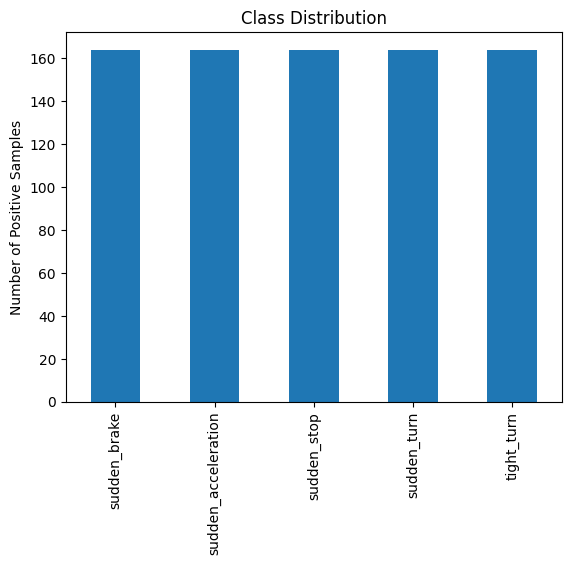

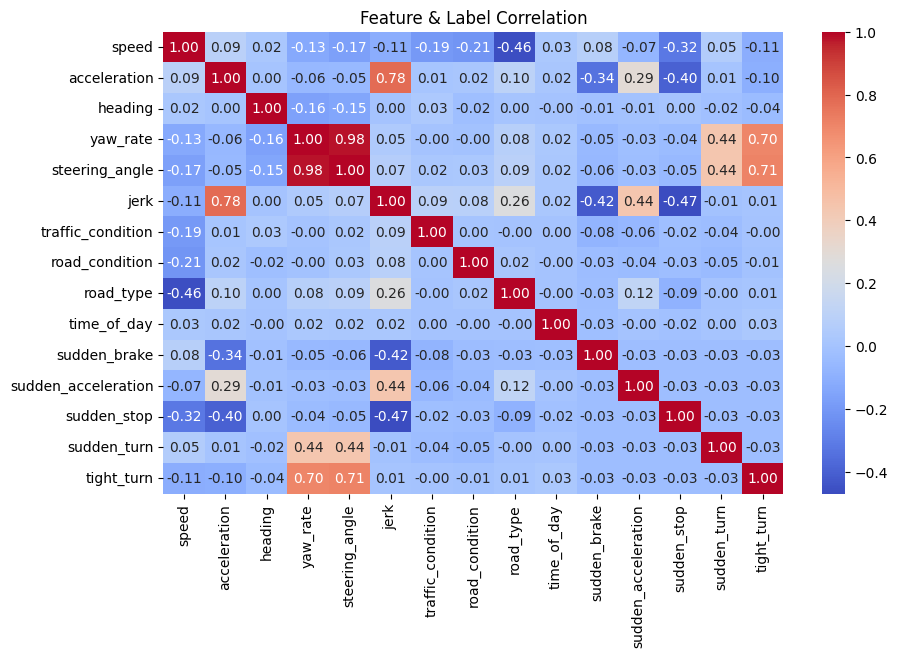

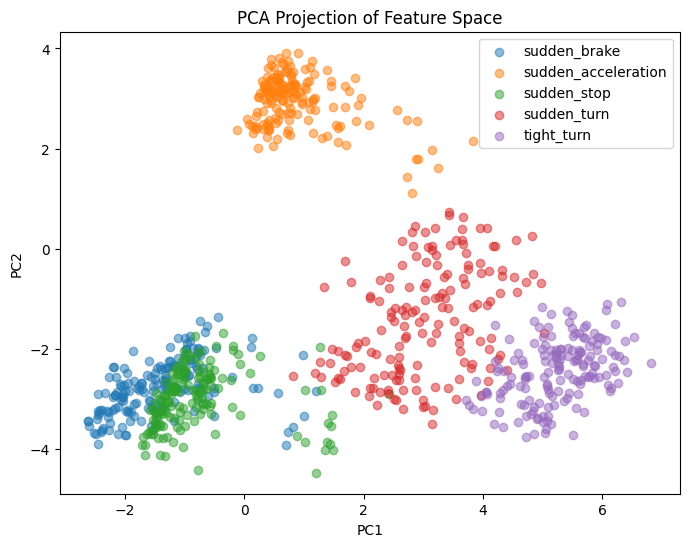

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ----- 1. Class Distribution -----
y.sum().plot(kind='bar', title='Class Distribution')
plt.ylabel("Number of Positive Samples")
plt.show()


# ----- 3. Correlation Heatmap -----
plt.figure(figsize=(10, 6))
sns.heatmap(df[X.columns.tolist() + y.columns.tolist()].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature & Label Correlation")
plt.show()

# ----- 4. PCA for Visualization -----
X_scaled = StandardScaler().fit_transform(X.fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for i, label in enumerate(y.columns):
    plt.scatter(X_pca[y[label]==1, 0], X_pca[y[label]==1, 1], label=label, alpha=0.5)
plt.legend()
plt.title("PCA Projection of Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [10]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:

rf = RandomForestClassifier(
    n_estimators=100,        
    max_depth=10,           
    min_samples_leaf=5,      
    max_features='sqrt',    
    random_state=42,
    n_jobs=-1                
)

gb = GradientBoostingClassifier(
    n_estimators=100,        
    learning_rate=0.05,      
    max_depth=3,             
    min_samples_leaf=5,
    subsample=0.8,           
    random_state=42
)
et = ExtraTreesClassifier(n_estimators=300, random_state=77)
lr = LogisticRegression(max_iter=1000, random_state=77)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('gb', gb),
    ('lr', lr),
    ('et', et)
    
], voting='soft')

multi_model = MultiOutputClassifier(voting_clf)
multi_model.fit(X_train, y_train)

y_pred = multi_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=1))

# joblib.dump(multi_model, 'anomaly_multi_model_ensemble.pkl')


                     precision    recall  f1-score   support

       sudden_brake       1.00      0.97      0.99        40
sudden_acceleration       1.00      1.00      1.00        35
        sudden_stop       1.00      1.00      1.00        33
        sudden_turn       1.00      0.96      0.98        27
         tight_turn       1.00      1.00      1.00        25

          micro avg       1.00      0.99      0.99       160
          macro avg       1.00      0.99      0.99       160
       weighted avg       1.00      0.99      0.99       160
        samples avg       1.00      1.00      1.00       160



In [12]:
import time
import numpy as np

sample_idx = 5
sample = X_test.iloc[sample_idx:sample_idx+1]

start_time = time.time()

y_pred_single = multi_model.predict(sample)

end_time = time.time()

response_time_ms = (end_time - start_time) * 1000  # milliseconds
print(f"Response time: {response_time_ms:.2f} ms")


Response time: 192.31 ms


In [9]:
import numpy as np
from sklearn.utils import shuffle

y_shuffled = shuffle(y, random_state=42)
should_not_be_accurate = multi_model.fit(X, y_shuffled)
y_pred = should_not_be_accurate.predict(X)

print(classification_report(y_shuffled, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       164
           2       0.00      0.00      0.00       164
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       164

   micro avg       0.00      0.00      0.00       820
   macro avg       0.00      0.00      0.00       820
weighted avg       0.00      0.00      0.00       820
 samples avg       0.00      0.00      0.00       820



d:\Safe_taxi\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Safe_taxi\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Safe_taxi\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Safe_taxi\venv\lib\site-packages\sklearn\metrics\_classification.p

In [16]:
single_row = X.iloc[[166]]
prediction = multi_model.predict(single_row)
import pandas as pd

pred_df = pd.DataFrame(prediction, columns=y.columns)
print(pred_df)
print(single_row)

   sudden_brake  sudden_acceleration  sudden_stop  sudden_turn  tight_turn
0             0                    0            0            1           0
     speed  acceleration  heading  yaw_rate  steering_angle  jerk  \
166  44.74           2.0    173.6     42.39           33.92   0.0   

     traffic_condition  road_condition  road_type  time_of_day  
166                  0               0          1            2  


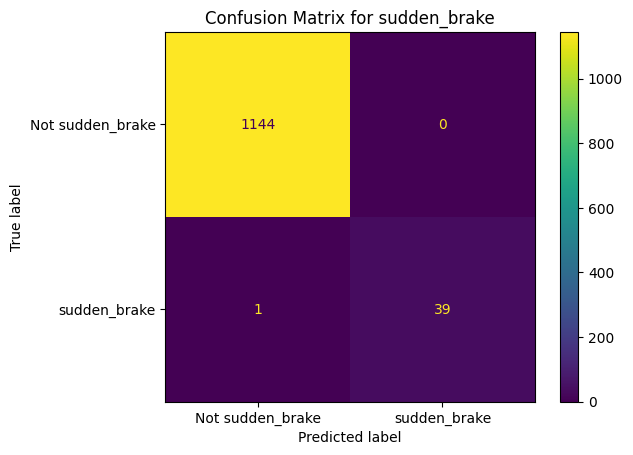

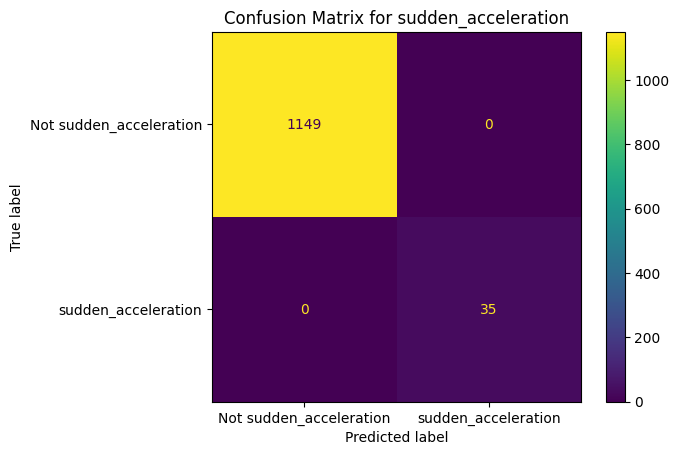

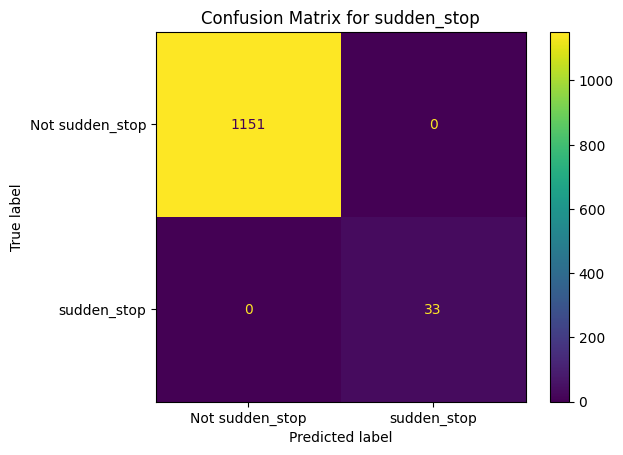

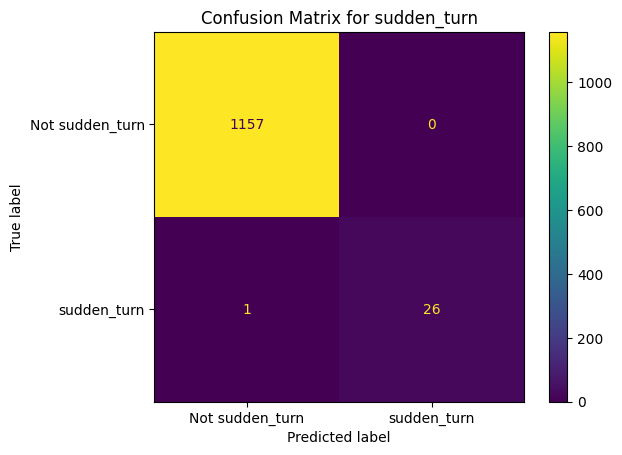

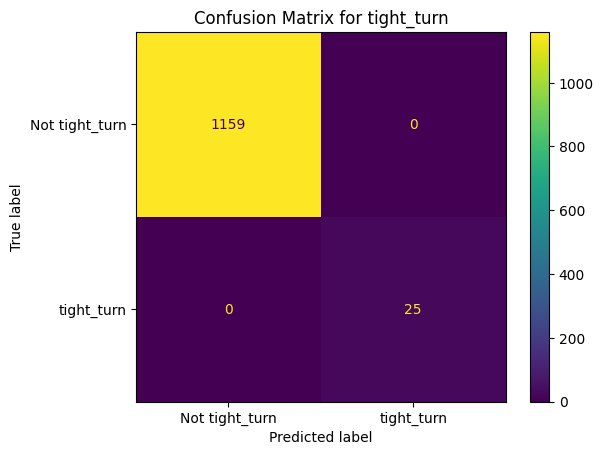

In [17]:
from sklearn.metrics import multilabel_confusion_matrix

labels = y.columns
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

for i, label in enumerate(labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrices[i], display_labels=[f'Not {label}', label])
    disp.plot()
    plt.title(f"Confusion Matrix for {label}")
    plt.show()


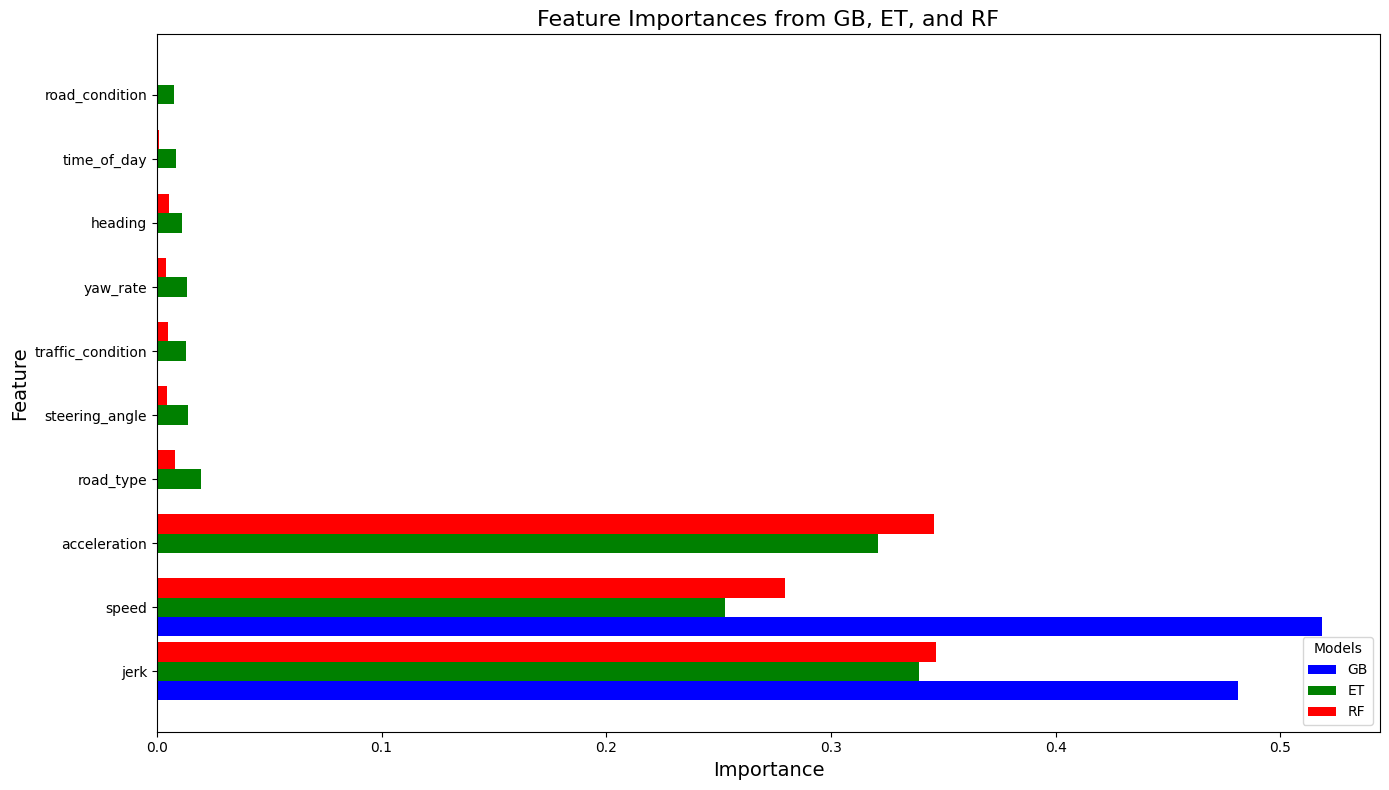

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


gb_model = multi_model.estimators_[0].named_estimators_['gb']
et_model = multi_model.estimators_[0].named_estimators_['et']
rf_model = multi_model.estimators_[0].named_estimators_['rf']

gb_importances = gb_model.feature_importances_
et_importances = et_model.feature_importances_
rf_importances = rf_model.feature_importances_
feat_names = X.columns

importances_df = pd.DataFrame({
    'Feature': feat_names,
    'GB': gb_importances,
    'ET': et_importances,
    'RF': rf_importances
})

importances_df['Average'] = importances_df[['GB', 'ET', 'RF']].mean(axis=1)
importances_df = importances_df.sort_values('Average', ascending=False)

plt.figure(figsize=(14, 8))

bar_width = 0.3 
index = np.arange(len(importances_df))  

plt.barh(index - bar_width, importances_df['GB'], bar_width, label='GB', color='blue')
plt.barh(index, importances_df['ET'], bar_width, label='ET', color='green')
plt.barh(index + bar_width, importances_df['RF'], bar_width, label='RF', color='red')

plt.title("Feature Importances from GB, ET, and RF", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.yticks(index, importances_df['Feature'])
plt.legend(title='Models', loc='lower right')

plt.tight_layout()
plt.show()
